# COMPSCI 753 Assignment 3

- UPI: shi995
- Name: Wennan Shi
- Student ID: 967146402

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

In [3]:
# Reload local python files every 2 seconds
%load_ext autoreload
%autoreload 2

## Task 1: Implementation of Power Iteration Algorithm

### (a) Implement the power iteration algorithm in matrix form without teleport

In [4]:
# Load the dataset
row = []
col = []
vote = []
with open('web-Google.txt', 'r') as f:
    for line in f:
        line = line.strip().split()
        int_line = [int(x) for x in line]
        col.append(int_line[0])
        row.append(int_line[1])
        vote.append(1)

In [5]:
# Initialize the adjacency matrix
M = csc_matrix((vote, (row, col)), shape = (875713, 875713))
M.data = M.data / np.repeat(np.add.reduceat(M.data, M.indptr[:-1]), np.diff(M.indptr))
M.shape

(875713, 875713)

In [6]:
# Implement the power iteration algorithm
def power_iteration(M, set_thredhold, set_beta):
    # Create a list to store leaked scores
    leaked_score = []
    # Set initial rank
    r_old = np.ones(875713) / 875713
    # Initialize threshold
    threshold = float('inf')
    # Initialize the counter
    iteration = 0
    while threshold >= set_thredhold:
        # Calculate the new rank
        r_new = set_beta * M.dot(r_old)
        # Update the rank
        r_new += np.ones(875713) * ((1 - set_beta) / 875713)
        # Calculate the leaked score
        leaked_score.append(1 - sum(r_new))
        # Update threshold ‖r(t+1) - r(t)‖1
        threshold = np.linalg.norm((r_new - r_old), ord = 1)
        # Overwrite the old rank
        r_old = r_new
        # Update the counter
        iteration += 1
    return iteration, r_new, leaked_score

### (b) Calculate the rank score for all the nodes and report

In [7]:
# Create function to generate top-10 list
def top_10(rank):
    top_10_id = rank.argsort()[::-1][0:10]
    top_10_score = rank[top_10_id]
    top_10_list = pd.DataFrame.from_dict({'ID': top_10_id, 'Score': top_10_score})
    return top_10_list

In [8]:
# Set start time
start = time.time()
iterations, rank, leaked_score = power_iteration(M, 0.02, 1)
# Set end time
end = time.time()
# Calculate runtime
runtime_power_iteration = round((end - start) * 1000, 2)
print('The running time is:', runtime_power_iteration, 'ms')
print('The number of iterations is:', iterations)
top_10(rank)

The running time is: 6181.67 ms
The number of iterations is: 62


,ID,Score
0,6116,0.000618
1,69056,0.000607
2,69055,0.000607
3,69057,0.000607
4,31563,0.000388
5,572672,0.000348
6,572673,0.000310
7,60232,0.000271
8,572674,0.000270
9,33676,0.000260


## Task 2: Report the leaked PageRank score in each iteration of Task 1 and explain

In [9]:
leaked_PageRank_score = pd.DataFrame.from_dict({'Iteration': np.arange(1, iterations + 1), 'Leaked score': leaked_score})
pd.set_option('display.max_rows', None)
leaked_PageRank_score

,Iteration,Leaked score
0,1,0.155598
1,2,0.239100
2,3,0.285303
3,4,0.320351
4,5,0.351836
5,6,0.379544
6,7,0.405129
7,8,0.428272
8,9,0.449842
9,10,0.469649


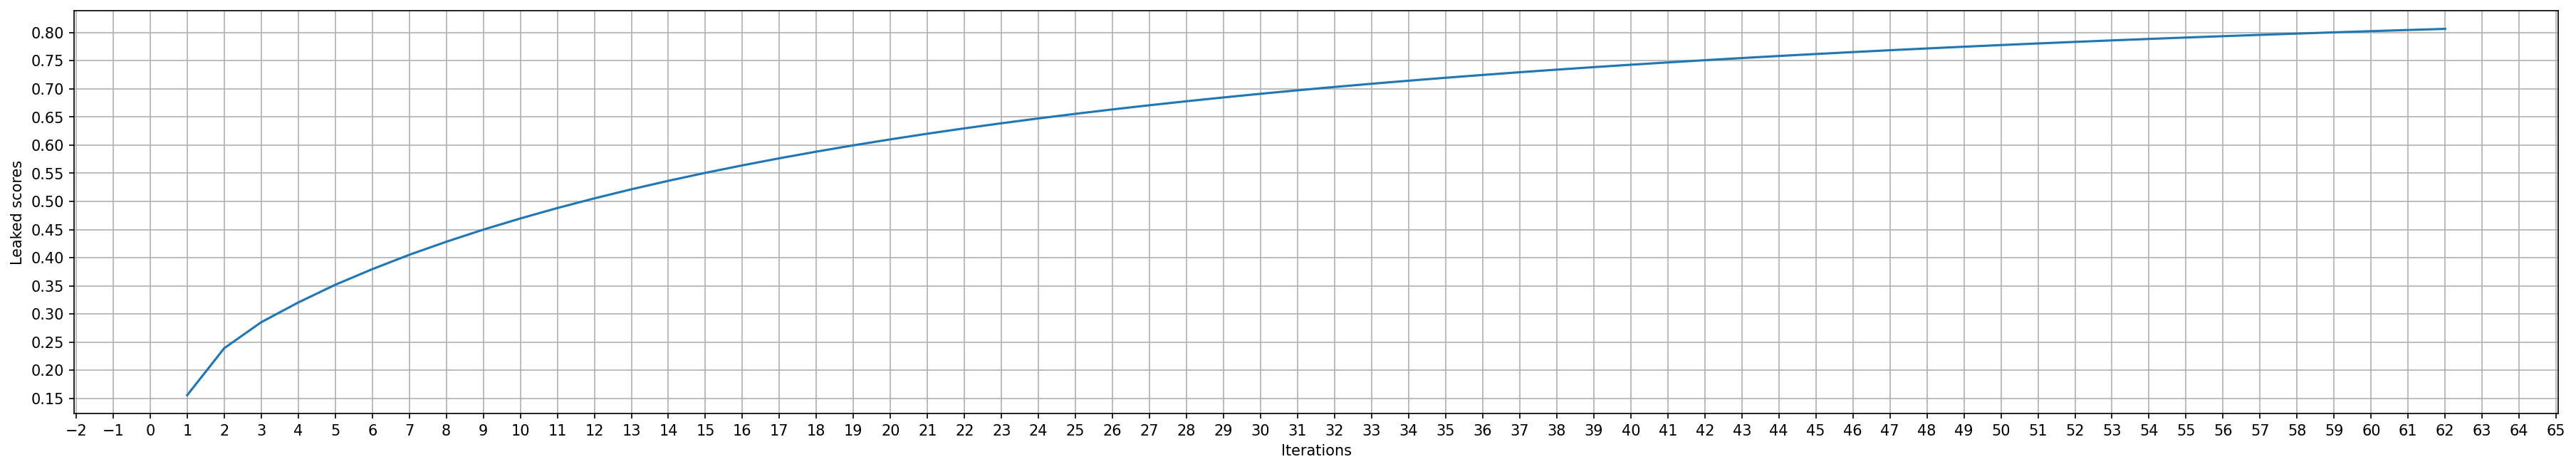

In [10]:
plt.figure(dpi = 150, figsize = (30,5))
x = leaked_PageRank_score['Iteration']
y = leaked_PageRank_score['Leaked score']
plt.plot(x, y)
plt.xlabel('Iterations')
plt.ylabel('Leaked scores')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.grid()
plt.show()

From the above result, it can observe that as the iterations increase, the leaked PageRank scores also increase. This is due to the effect of dead ends was not considered in Task 1. In fact, dead ends are like black holes, constantly absorbing the PageRank scores from other nodes, eventually leading to 0 scores for other nodes.

## Task 3: Implementation of Teleport

### (a) Extend the PageRank code to handle both spider traps and dead ends using the idea of teleport

In [11]:
# Extend the PageRank code
def PageRank(M, set_thredhold, set_beta):
    # Set initial rank
    r_old = np.ones(875713) / 875713
    # Initialize threshold
    threshold = float('inf')
    # Initialize the counter
    iteration = 0
    while threshold >= set_thredhold:
        # Calculate the new rank
        r_new = set_beta * M.dot(r_old)
        # In standard PageRank, every node is in the teleport set
        S = sum(r_new)
        # Update the rank
        r_new += np.ones(875713) * ((1 - S) / 875713)
        # Update threshold ‖r(t+1) - r(t)‖1
        threshold = np.linalg.norm((r_new - r_old), ord = 1)
        # Overwrite the old rank
        r_old = r_new
        # Update the counter
        iteration += 1
    return iteration, r_new

### (b) Run the code on the Google web data and report

In [12]:
# Set start time
start = time.time()
iterations, rank = PageRank(M, 0.02, 0.9)
# Set end time
end = time.time()
# Calculate runtime
runtime_PageRank = round((end - start) * 1000, 2)
print('The running time is:', runtime_PageRank, 'ms')
print('The number of iterations is:', iterations)
top_10(rank)

The running time is: 1139.29 ms
The number of iterations is: 11


,ID,Score
0,2138,0.001009
1,115,0.000971
2,3178,0.000938
3,2560,0.000931
4,1950,0.000851
5,1181,0.000811
6,903,0.000783
7,1611,0.000757
8,3150,0.000754
9,3180,0.000740


### (c) By varying the teleport probability β, report the number of iterations for each β

In [13]:
beta_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
iteration_list = []
for beta in beta_list:
    iterations, rank = PageRank(M, 0.02, beta)
    iteration_list.append(iterations)
iteration_table = pd.DataFrame.from_dict({'Beta': beta_list, 'Iteration': iteration_list})
iteration_table

,Beta,Iteration
0,1.0,90
1,0.9,11
2,0.8,7
3,0.7,6
4,0.6,5
5,0.5,4


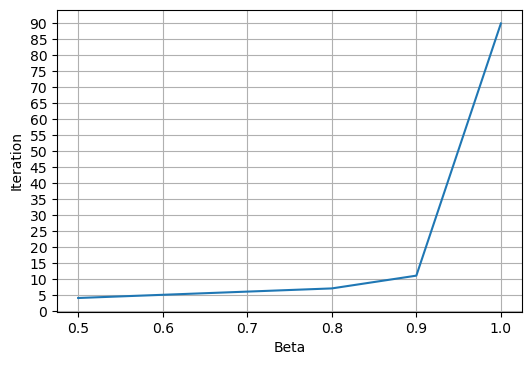

In [14]:
plt.figure(dpi = 100)
x = iteration_table['Beta']
y = iteration_table['Iteration']
plt.plot(x, y)
plt.xlabel('Beta')
plt.ylabel('Iteration')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
plt.grid()
plt.show()

From the above result, it can observe that as β increases, the number of iterations also increases. Because when β is larger, the probability of random jumps is smaller.  
When β is 1, means no random jumps, all nodes follow their outlinks to propagate information, so the number of iterations needed to stop increases sharply, and the running time will be longer.  
Conversely, when β is smaller, the probability of random jumps is larger, and the PageRank scores will be more evenly spread to all nodes. If when β is 0, all nodes teleport randomly and no longer follow their outlinks, the running time will be faster.  
In practice, people usually take β as 0.85.